In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
cur_path = "/content/drive/MyDrive/graph-fraud-detection/"
os.chdir(cur_path)
!pwd

/content/drive/MyDrive/graph-fraud-detection


In [3]:
!pip install dgl
#-cu101

     |████████████████████████████████| 4.4MB 6.6MB/s 


In [4]:
import os
import sys
import glob

os.environ['DGLBACKEND'] = 'pytorch'

import torch as th
import dgl
import numpy as np

from gnn.estimator_fns import *
from gnn.graph_utils import *
from gnn.data import *
from gnn.utils import *
from gnn.pytorch_model import *
from gnn.train import *

Using backend: pytorch


DLG version: 0.6.1


Recall the edges we defined before and the csv files we used to save them.

In [5]:
file_list = glob.glob('./data/*edgelist.csv')

edges = ",".join(map(lambda x: x.split("/")[-1], [file for file in file_list if "relation" in file]))

To train the graph neural network, we need to define a few hyperparameters that determine properties such as the class of graph neural network models we will be using, the network architecture and the optimizer and optimization parameters.

Here we're setting only a few of the hyperparameters, to see all the hyperparameters and their default values, see `gnn/estimator_fns.py`. The parameters set below are:

- **nodes** is the name of the file that contains the node_ids of the target nodes and the node features.
- **edges** is a regular expression that when expanded lists all the filenames for the edgelists
- **labels** is the name of the file tha contains the target node_ids and their labels
- **model** specify which graph neural network to use, this should be set to r-gcn

The following hyperparameters can be tuned and adjusted to improve model performance

- **batch-size** is the number nodes that are used to compute a single forward pass of the GNN
- **embedding-size** is the size of the embedding dimension for non target nodes
- **n-neighbors** is the number of neighbours to sample for each target node during graph sampling for mini-batch training
- **n-layers** is the number of GNN layers in the model
- **n-epochs** is the number of training epochs for the model training job
- **optimizer** is the optimization algorithm used for gradient based parameter updates
- **lr** is the learning rate for parameter updates

In [7]:
print('numpy version:{} PyTorch version:{} DGL version:{}'.format(np.__version__,
                                                                    th.__version__,
                                                                    dgl.__version__))

args = parse_args()
print(args)

numpy version:1.19.5 PyTorch version:1.8.1+cu101 DGL version:0.6.1
Namespace(compute_metrics=True, dropout=0.2, edges='relation*', embedding_size=360, labels='tags.csv', lr=0.01, model_dir='./model/2021_05_02_23_34_23', n_epochs=500, n_hidden=16, n_layers=3, new_accounts='test.csv', nodes='features.csv', num_gpus=0, optimizer='adam', output_dir='./output', target_ntype='TransactionID', threshold=0, training_dir='./data', weight_decay=0.0005)


In [8]:
args.edges = edges

args.edges = get_edgelists('relation*', args.training_dir)

g, features, target_id_to_node, id_to_node = construct_graph(args.training_dir,
                                                                args.edges,
                                                                args.nodes,
                                                                args.target_ntype)

mean, stdev, features = normalize(th.from_numpy(features))

print('feature mean shape:{}, std shape:{}'.format(mean.shape, stdev.shape))

Getting relation graphs from the following edge lists : ['relation_card1_edgelist.csv', 'relation_card2_edgelist.csv', 'relation_card3_edgelist.csv', 'relation_card4_edgelist.csv', 'relation_card6_edgelist.csv', 'relation_card5_edgelist.csv', 'relation_ProductCD_edgelist.csv', 'relation_addr1_edgelist.csv', 'relation_addr2_edgelist.csv', 'relation_R_emaildomain_edgelist.csv', 'relation_P_emaildomain_edgelist.csv', 'relation_id_04_edgelist.csv', 'relation_id_01_edgelist.csv', 'relation_id_03_edgelist.csv', 'relation_id_02_edgelist.csv', 'relation_TransactionID_edgelist.csv', 'relation_id_10_edgelist.csv', 'relation_id_07_edgelist.csv', 'relation_id_06_edgelist.csv', 'relation_id_09_edgelist.csv', 'relation_id_05_edgelist.csv', 'relation_id_08_edgelist.csv', 'relation_id_13_edgelist.csv', 'relation_id_12_edgelist.csv', 'relation_id_14_edgelist.csv', 'relation_id_15_edgelist.csv', 'relation_id_11_edgelist.csv', 'relation_id_19_edgelist.csv', 'relation_id_16_edgelist.csv', 'relation_id_18_

In [9]:
g.nodes['target'].data['features'] = features

print("Getting labels")
n_nodes = g.number_of_nodes('target')

labels, _, test_mask = get_labels(target_id_to_node,
                                            n_nodes,
                                            args.target_ntype,
                                            os.path.join(args.training_dir, args.labels),
                                            os.path.join(args.training_dir, args.new_accounts))
print("Got labels")

labels = th.from_numpy(labels).float()
test_mask = th.from_numpy(test_mask).float()

n_nodes = th.sum(th.tensor([g.number_of_nodes(n_type) for n_type in g.ntypes]))
n_edges = th.sum(th.tensor([g.number_of_edges(e_type) for e_type in g.etypes]))

print("""----Data statistics------'
            #Nodes: {}
            #Edges: {}
            #Features Shape: {}
            #Labeled Test samples: {}""".format(n_nodes,
                                                    n_edges,
                                                    features.shape,
                                                    test_mask.sum()))

Getting labels
Got labels
----Data statistics------'
            #Nodes: 726345
            #Edges: 19518802
            #Features Shape: torch.Size([590540, 390])
            #Labeled Test samples: 118108.0


In [10]:
if args.num_gpus:
    cuda = True
    device = th.device('cuda:0')
else:
    cuda = False
    device = th.device('cpu')

Initializing Model
Initialized Model
Starting Model training
Epoch 00000 | Time(s) 32.3688 | Loss 0.6646 | f1 0.0000 
Epoch 00001 | Time(s) 30.8934 | Loss 0.7161 | f1 0.0000 
Epoch 00002 | Time(s) 30.0499 | Loss 0.4767 | f1 0.0067 
Epoch 00003 | Time(s) 29.6715 | Loss 0.1787 | f1 0.1372 
Epoch 00004 | Time(s) 29.3338 | Loss 1.7155 | f1 0.0004 
Epoch 00005 | Time(s) 29.1633 | Loss 0.2276 | f1 0.0000 
Epoch 00006 | Time(s) 29.0614 | Loss 0.3667 | f1 0.0000 
Epoch 00007 | Time(s) 28.9540 | Loss 0.4213 | f1 0.0000 
Epoch 00008 | Time(s) 28.8704 | Loss 0.4221 | f1 0.0000 
Epoch 00009 | Time(s) 28.8388 | Loss 0.3901 | f1 0.0000 
Epoch 00010 | Time(s) 28.7927 | Loss 0.3390 | f1 0.0000 
Epoch 00011 | Time(s) 28.7441 | Loss 0.2834 | f1 0.0000 
Epoch 00012 | Time(s) 28.7157 | Loss 0.2344 | f1 0.0000 
Epoch 00013 | Time(s) 28.6949 | Loss 0.2040 | f1 0.0000 
Epoch 00014 | Time(s) 28.6310 | Loss 0.1884 | f1 0.0214 
Epoch 00015 | Time(s) 28.6095 | Loss 0.2013 | f1 0.1177 
Epoch 00016 | Time(s) 28.61

2021-05-03 05:28:00,010 INFO numexpr.utils: NumExpr defaulting to 4 threads.


Model and metadata saved


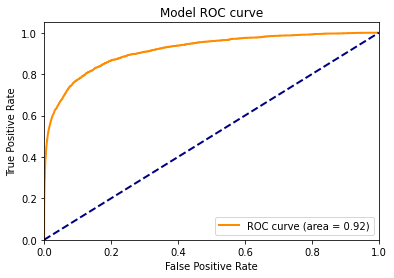

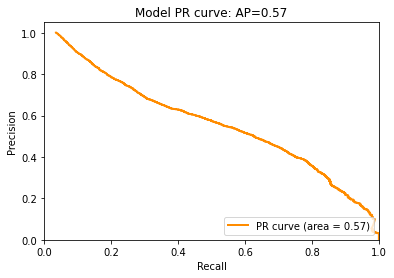

In [11]:
print("Initializing Model")
in_feats = features.shape[1]
n_classes = 2

ntype_dict = {n_type: g.number_of_nodes(n_type) for n_type in g.ntypes}

model = get_model(ntype_dict, g.etypes, vars(args), in_feats, n_classes, device)
print("Initialized Model")

features = features.to(device)

labels = labels.long().to(device)
test_mask = test_mask.to(device)
# g = g.to(device)

loss = th.nn.CrossEntropyLoss()

# print(model)
optim = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

print("Starting Model training")
model, class_preds, pred_proba = train_fg(model, optim, loss, features, labels, g, g,
                                            test_mask, device, args.n_epochs,
                                            args.threshold,  args.compute_metrics)
print("Finished Model training")

print("Saving model")

if not os.path.exists(args.model_dir):
    os.makedirs(args.model_dir)

save_model(g, model, args.model_dir, id_to_node, mean, stdev)
print("Model and metadata saved")

In [ ]:
%tb

No traceback available to show.
